# Experiments with modelling funcs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


In [54]:
def plot_func(fn, xvals, ax=None):
    yvals = [fn(x) for x in xvals]
    if ax:
        ax.plot(xvals,yvals)
    else:
        plt.plot(xvals,yvals)
        ax = plt.gca()
    return ax

In [3]:
# Polynomial func
def generate_poly_func(xp, yp, deg=1):
    z = np.polyfit(xp, yp, deg)
    p = np.poly1d(z)
    return p

def scipy_fit(func, xp, yp, sigma=None):
    popt, pcov = curve_fit(func, xp, yp, sigma=sigma, method='dogbox', absolute_sigma = True)
    return lambda x: func(x, *popt)

def optimus_curve(x, b0, b1, b2):
    return (1-(1/(b0*x + b1) + b2))#np.min((1-(1/(b0*x + b1) + b2)), np.array([1]*len(x)))

def log_curve(x, a, b, c):
    return a * np.exp(-b * x) + c

In [4]:
xp = [1,2,3,4]
yp = [1,2,3,4]
plot_space = np.linspace(0,10,20)

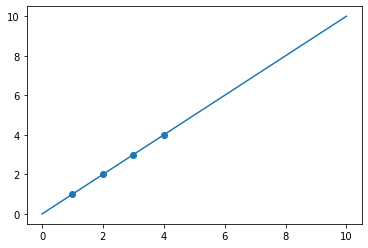

In [5]:
linear_func = generate_poly_func(xp,yp,deg=1)
ax=plot_func(linear_func, plot_space)
ax.scatter(xp,yp)

[0.75       0.91542285 0.95      ]


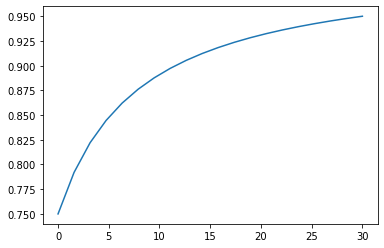

In [6]:
orig_xp = [0,30]
orig_yp = [0.75, 0.95]
orig_curve = scipy_fit(optimus_curve, orig_xp, orig_yp)

plot_space = np.linspace(0,30,20)
ax=plot_func(orig_curve, plot_space)

# Create booster pts to assign more weights to curve and account for errors
weight = 1
booster_pts_x = np.linspace(0,30, weight+2)
booster_pts_y = orig_curve(booster_pts_x)
print(booster_pts_y)

In [7]:
print(xp)
np.array(xp)/np.array(yp)

[1, 2, 3, 4]


array([1., 1., 1., 1.])

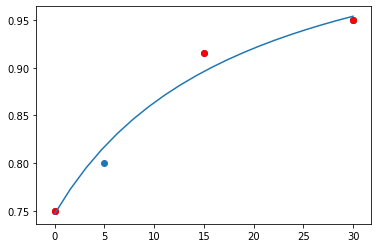

In [8]:
# Use booster pts with microprofile info
microprofile_epochs = 5
microprofile_acc = 0.8

xp = np.concatenate([booster_pts_x, orig_xp, [microprofile_epochs]])
yp = np.concatenate([booster_pts_y, orig_yp, [microprofile_acc]])
fn = scipy_fit(optimus_curve, xp, yp)

plot_space = np.linspace(0,30,20)
ax=plot_func(fn, plot_space)
ax.scatter(xp,yp)
ax.scatter(booster_pts_x,booster_pts_y,color='r')

In [9]:
np.concatenate([booster_pts_x, orig_xp, [1]])

array([ 0., 15., 30.,  0., 30.,  1.])

In [10]:
xp = [0,5,30]
yp = [0.75, 0.76, 0.95]
sigmas = [0.01, 0.3, 0.01]
plot_space = np.linspace(0,30,20)
fn = scipy_fit(optimus_curve, xp, yp, sigmas)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [ ]:
ax=plot_func(fn, plot_space)
ax.scatter(xp,yp)

In [64]:
def get_scaled_optimus_fn(microprofile_x: np.array,
                          microprofile_y: np.array,
                          start_acc: float,
                          end_acc: float,
                          end_epochs: float,
                          weight: int,
                          microprofile_expectation_factor: float = 0.9):
    '''
    Generates an approximation of the optimus curve and also scales the final accuracy proportional to microprofiling deviation from expected value. Weighs the start_acc and end_acc points more heavily (according to weight).
    to account for errors in microprofiling
    :param microprofile_expectation_factor: Expected reduction in microprofile accuracies.
    :param start_acc: Starting accuracy
    :param end_acc: End accuracy
    :param end_epochs: The number of epochs to achieve end accuracy
    :param weight: Sets the number of points to be fetched from the seed_curve for use in final curve estimation. Indirectly sets weights for the seed points.
    :param microprofile_x:
    :param microprofile_y:
    :return:
    '''
    # Generate seed curve
    seed_x = np.array([0, end_epochs])
    seed_y = np.array([start_acc, end_acc])
    seed_curve = scipy_fit(optimus_curve, seed_x, seed_y)

    # Calculate the deviation of the microprofiles and generate new curve to fit that.
    microprofile_expected_values = seed_curve(microprofile_x)
    max_factor = 1/end_acc
    mean_microprofile_deviation = min(np.mean(microprofile_y/(microprofile_expected_values*microprofile_expectation_factor)), max_factor)
    new_end_acc = end_acc*mean_microprofile_deviation
    new_seed_y = np.array([start_acc, new_end_acc])
    seed_curve = scipy_fit(optimus_curve, seed_x, new_seed_y)

    # Generate booster points for the new_seed_curve
    booster_pts_x = np.linspace(min(seed_x), max(seed_x), weight + 2)
    booster_pts_y = seed_curve(booster_pts_x)

    xp = np.concatenate([booster_pts_x, seed_x, microprofile_x])
    yp = np.concatenate([booster_pts_y, new_seed_y, microprofile_y])
    fn = scipy_fit(optimus_curve, xp, yp)
    return fn

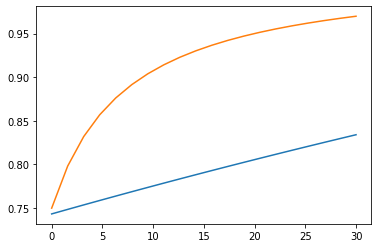

In [68]:
fn = get_scaled_optimus_fn(microprofile_x=np.array([5]),
                           microprofile_y=np.array([0.73]),
                           start_acc=0.75,
                           end_acc=0.9,
                           end_epochs=30,
                           weight=2,
                           microprofile_expectation_factor=0.98)

ax=plot_func(fn, plot_space)

fn2 = get_scaled_optimus_fn(microprofile_x=np.array([5]),
                           microprofile_y=np.array([0.85]),
                           start_acc=0.75,
                           end_acc=0.9,
                           end_epochs=30,
                           weight=5,
                           microprofile_expectation_factor=0.98)
plot_func(fn2, plot_space)